In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from pyspark.sql import SparkSession, functions, types
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, mean, stddev,stddev_pop,avg,max,to_timestamp,udf,desc
from pyspark.sql import Window

In [3]:
spark = SparkSession.builder.appName('weather prediction').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
assert spark.version >= '2.4'  # make sure we have Spark 2.4+

## Schema Set

In [4]:
input = 'EDS_2.csv'
# Defining the schema for tmax datasets
def sensor_schema():
    sen_schema = types.StructType([
        types.StructField('timestamp', types.StringType()),
        types.StructField('X', types.DoubleType()),
        types.StructField('Y', types.DoubleType()),
        types.StructField('Z', types.DoubleType()),
    ])
    return sen_schema

sens_schema = sensor_schema()
#Spark read of data
temp = spark.read.csv(input, schema=sens_schema)

## Initial Filter to obtain useful Data. Other ranges are useless

In [7]:
temp.createOrReplaceTempView("temp")
temp = spark.sql("select timestamp,Z from temp where timestamp between '2018-07-09 12:00:00' and '2018-08-09 12:00:00'")

## Standard Scaler - Z normalization

In [8]:
# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),6), types.DoubleType())

assembler = VectorAssembler(
    inputCols=["Z"],
    outputCol="Zvector")
tempdata = assembler.transform(temp)
scaler = StandardScaler(inputCol="Zvector", outputCol="Zscale",withMean=True, withStd=True)
scalerModel = scaler.fit(tempdata)
scaledData = scalerModel.transform(tempdata).withColumn("Zscale", unlist("Zscale")).drop("Zvector").cache()
scaledData.show()

+--------------------+--------+---------+
|           timestamp|       Z|   Zscale|
+--------------------+--------+---------+
|2018-07-09 12:00:...|0.859375| 0.381253|
|2018-07-09 12:00:...|0.859375| 0.381253|
|2018-07-09 12:00:...|0.859375| 0.381253|
|2018-07-09 12:00:...|0.855469|-0.021926|
|2018-07-09 12:00:...|0.855469|-0.021926|
|2018-07-09 12:00:...|0.851563|-0.425104|
|2018-07-09 12:00:...|0.859375| 0.381253|
|2018-07-09 12:00:...|0.855469|-0.021926|
|2018-07-09 12:00:...|0.855469|-0.021926|
|2018-07-09 12:00:...|0.851563|-0.425104|
|2018-07-09 12:00:...|0.855469|-0.021926|
|2018-07-09 12:00:...|0.851563|-0.425104|
|2018-07-09 12:00:...|0.859375| 0.381253|
|2018-07-09 12:00:...|0.855469|-0.021926|
|2018-07-09 12:00:...|0.859375| 0.381253|
|2018-07-09 12:00:...|0.859375| 0.381253|
|2018-07-09 12:00:...|0.851563|-0.425104|
|2018-07-09 12:00:...|0.855469|-0.021926|
|2018-07-09 12:00:...|0.855469|-0.021926|
|2018-07-09 12:00:...|0.855469|-0.021926|
+--------------------+--------+---

## Exploratory Findings

In [9]:
#Below code is to find distribution of values for the entire filtered time period. This might help in finding 
#frequent model cases
#Round the Zscale value to 0
scaledData.createOrReplaceTempView("scaledData")
scaledNorm = spark.sql("select timestamp,Z,Zscale,round(Zscale,0) as Zround from scaledData")
scaledNorm.show()
#Select only rounded values
scaledNorm.createOrReplaceTempView("scaledNorm")
scaledRound = spark.sql("select distinct(Zround),count(Zround) from scaledNorm group by Zround")
scaledRound.show()

+--------------------+--------+---------+------+
|           timestamp|       Z|   Zscale|Zround|
+--------------------+--------+---------+------+
|2018-07-09 12:00:...|0.859375| 0.381253|   0.0|
|2018-07-09 12:00:...|0.859375| 0.381253|   0.0|
|2018-07-09 12:00:...|0.859375| 0.381253|   0.0|
|2018-07-09 12:00:...|0.855469|-0.021926|   0.0|
|2018-07-09 12:00:...|0.855469|-0.021926|   0.0|
|2018-07-09 12:00:...|0.851563|-0.425104|   0.0|
|2018-07-09 12:00:...|0.859375| 0.381253|   0.0|
|2018-07-09 12:00:...|0.855469|-0.021926|   0.0|
|2018-07-09 12:00:...|0.855469|-0.021926|   0.0|
|2018-07-09 12:00:...|0.851563|-0.425104|   0.0|
|2018-07-09 12:00:...|0.855469|-0.021926|   0.0|
|2018-07-09 12:00:...|0.851563|-0.425104|   0.0|
|2018-07-09 12:00:...|0.859375| 0.381253|   0.0|
|2018-07-09 12:00:...|0.855469|-0.021926|   0.0|
|2018-07-09 12:00:...|0.859375| 0.381253|   0.0|
|2018-07-09 12:00:...|0.859375| 0.381253|   0.0|
|2018-07-09 12:00:...|0.851563|-0.425104|   0.0|
|2018-07-09 12:00:..

In [10]:
spark.conf.set("spark.sql.execution.arrow.enabled","true")
%time temp_dist = scaledRound.toPandas()
temp_dist.to_csv('Lift2_dist.csv',index=False)

CPU times: user 39.9 ms, sys: 9.85 ms, total: 49.7 ms
Wall time: 5.53 s


In [290]:
scaledData.createOrReplaceTempView("scale")
normaldata = spark.sql("select timestamp,Z,Zscale from scale where Z > 0.920 and Z < 0.930")
normaldata.show()

+--------------------+--------+--------+
|           timestamp|       Z|  Zscale|
+--------------------+--------+--------+
|2018-07-09 12:07:...|0.921875| 6.83252|
|2018-07-09 12:07:...|0.921875| 6.83252|
|2018-07-09 12:07:...|0.925781|7.235698|
|2018-07-09 12:07:...|0.925781|7.235698|
|2018-07-09 12:08:...|0.921875| 6.83252|
|2018-07-09 12:08:...|0.921875| 6.83252|
|2018-07-09 12:08:...|0.925781|7.235698|
|2018-07-09 12:08:...|0.921875| 6.83252|
|2018-07-09 12:08:...|0.921875| 6.83252|
|2018-07-09 12:08:...|0.929688| 7.63898|
|2018-07-09 12:08:...|0.925781|7.235698|
|2018-07-09 12:08:...|0.929688| 7.63898|
|2018-07-09 12:08:...|0.929688| 7.63898|
|2018-07-09 12:08:...|0.925781|7.235698|
|2018-07-09 12:08:...|0.921875| 6.83252|
|2018-07-09 12:08:...|0.921875| 6.83252|
|2018-07-09 12:08:...|0.925781|7.235698|
|2018-07-09 12:08:...|0.921875| 6.83252|
|2018-07-09 12:08:...|0.921875| 6.83252|
|2018-07-09 12:08:...|0.921875| 6.83252|
+--------------------+--------+--------+
only showing top

In [6]:
scaledData.sort(desc("Zscale")).show()

+--------------------+--------+---------+
|           timestamp|       Z|   Zscale|
+--------------------+--------+---------+
|2018-08-03 10:58:...|1.066406|21.751049|
|2018-08-03 10:17:...| 1.03125|18.122237|
|2018-08-03 10:43:...|1.027344|17.719059|
|2018-08-03 11:13:...|1.027344|17.719059|
|2018-08-03 10:21:...|1.023438| 17.31588|
|2018-08-03 10:13:...|1.023438| 17.31588|
|2018-08-03 10:07:...|1.023438| 17.31588|
|2018-08-03 10:01:...|1.019531|16.912599|
|2018-08-03 09:59:...|1.019531|16.912599|
|2018-08-03 10:58:...|1.019531|16.912599|
|2018-08-03 10:01:...|1.015625| 16.50942|
|2018-08-03 11:12:...|1.015625| 16.50942|
|2018-08-03 10:05:...|1.015625| 16.50942|
|2018-08-03 11:13:...|1.015625| 16.50942|
|2018-08-03 10:15:...|1.015625| 16.50942|
|2018-08-03 10:07:...|1.011719|16.106242|
|2018-08-03 11:14:...|1.011719|16.106242|
|2018-08-03 10:57:...|1.011719|16.106242|
|2018-08-03 11:09:...|1.011719|16.106242|
|2018-07-31 11:24:...|1.011719|16.106242|
+--------------------+--------+---

In [144]:
scaledData.sort("Zscale").show(50)

+--------------------+--------+----------+
|           timestamp|       Z|    Zscale|
+--------------------+--------+----------+
|2018-08-03 11:09:...|   0.625|-23.810999|
|2018-08-03 11:09:...|   0.625|-23.810999|
|2018-08-03 10:17:...|0.652344|-20.988544|
|2018-08-03 11:09:...| 0.65625|-20.585365|
|2018-08-03 11:09:...| 0.65625|-20.585365|
|2018-07-19 22:18:...|0.667969|-19.375727|
|2018-08-03 10:57:...|0.667969|-19.375727|
|2018-08-03 10:17:...|0.671875|-18.972549|
|2018-08-03 11:12:...|0.671875|-18.972549|
|2018-08-03 10:48:...|0.675781| -18.56937|
|2018-08-03 10:55:...|0.679688|-18.166089|
|2018-08-03 10:35:...|0.679688|-18.166089|
|2018-08-03 11:09:...|0.679688|-18.166089|
|2018-08-03 10:26:...|  0.6875|-17.359732|
|2018-08-03 10:19:...|  0.6875|-17.359732|
|2018-07-19 22:18:...|  0.6875|-17.359732|
|2018-08-03 10:45:...|  0.6875|-17.359732|
|2018-08-03 10:04:...|0.691406|-16.956554|
|2018-08-03 10:19:...|0.691406|-16.956554|
|2018-07-12 09:29:...|0.691406|-16.956554|
|2018-08-03

## Selection of time ranges to plot based on EDA findings

In [326]:
scaledData.createOrReplaceTempView("scaledData")
temp_df = spark.sql("select timestamp,Z,Zscale from scaledData where timestamp between '2018-07-09 12:07:30' and '2018-07-09 12:09:10'").cache()

In [327]:
temp_df = temp_df.withColumn("timestamp1", to_timestamp("timestamp", 'yyyy-MM-dd HH:mm:ss')).cache()
temp_df.show()

+--------------------+--------+---------+-------------------+
|           timestamp|       Z|   Zscale|         timestamp1|
+--------------------+--------+---------+-------------------+
|2018-07-09 12:07:...|0.859375| 0.381253|2018-07-09 12:07:30|
|2018-07-09 12:07:...|0.855469|-0.021926|2018-07-09 12:07:30|
|2018-07-09 12:07:...|0.855469|-0.021926|2018-07-09 12:07:30|
|2018-07-09 12:07:...|0.847656|-0.828386|2018-07-09 12:07:30|
|2018-07-09 12:07:...|0.847656|-0.828386|2018-07-09 12:07:30|
|2018-07-09 12:07:...|0.859375| 0.381253|2018-07-09 12:07:30|
|2018-07-09 12:07:...|0.851563|-0.425104|2018-07-09 12:07:30|
|2018-07-09 12:07:...|0.859375| 0.381253|2018-07-09 12:07:30|
|2018-07-09 12:07:...|0.859375| 0.381253|2018-07-09 12:07:30|
|2018-07-09 12:07:...|0.859375| 0.381253|2018-07-09 12:07:30|
|2018-07-09 12:07:...|0.851563|-0.425104|2018-07-09 12:07:30|
|2018-07-09 12:07:...|0.859375| 0.381253|2018-07-09 12:07:30|
|2018-07-09 12:07:...|0.855469|-0.021926|2018-07-09 12:07:30|
|2018-07

In [317]:
movAvg = temp_df.withColumn("movingAverage", avg(temp_df["Zscale"])
             .over( Window.partitionBy(temp_df["timestamp1"]).rowsBetween(-5,5))).cache()
movAvg.show()

+--------------------+--------+---------+-------------------+-------------------+
|           timestamp|       Z|   Zscale|         timestamp1|      movingAverage|
+--------------------+--------+---------+-------------------+-------------------+
|2018-07-09 12:08:...|0.835938|-2.037921|2018-07-09 12:08:44|-2.6427401666666666|
|2018-07-09 12:08:...|0.835938|-2.037921|2018-07-09 12:08:44|-2.8443514285714286|
|2018-07-09 12:08:...|0.835938|-2.037921|2018-07-09 12:08:44|        -3.04595725|
|2018-07-09 12:08:...|0.828125|-2.844381|2018-07-09 12:08:44|-3.2475593333333332|
|2018-07-09 12:08:...|0.824219|-3.247559|2018-07-09 12:08:44|         -3.3685232|
|2018-07-09 12:08:...|0.820313|-3.650738|2018-07-09 12:08:44| -3.504146181818182|
|2018-07-09 12:08:...|0.816406|-4.054019|2018-07-09 12:08:44|-3.7607330000000005|
|2018-07-09 12:08:...|  0.8125|-4.457198|2018-07-09 12:08:44|-3.9806672727272727|
|2018-07-09 12:08:...|0.808594|-4.860376|2018-07-09 12:08:44| -4.310568636363637|
|2018-07-09 12:0

In [275]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [199]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 9.11 ms, sys: 3.8 ms, total: 12.9 ms
Wall time: 63 ms


### Plots of Anomalies detected for Lift 1. 10 different anomalies are plotted here

### Anomaly 1

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

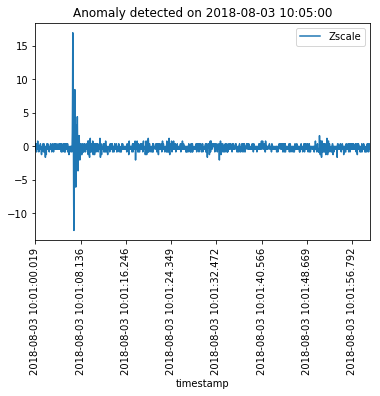

In [55]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-08-03 10:01:00")
plt.xticks(rotation=90)

### Anomaly 2

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

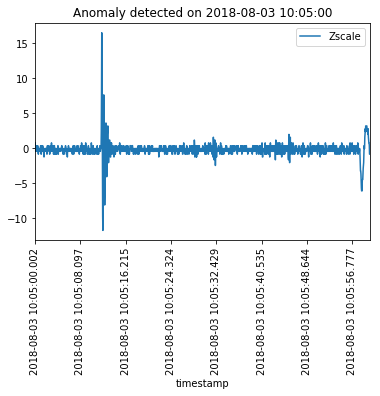

In [63]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-08-03 10:05:00")
plt.xticks(rotation=90)

### Anomaly 3

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

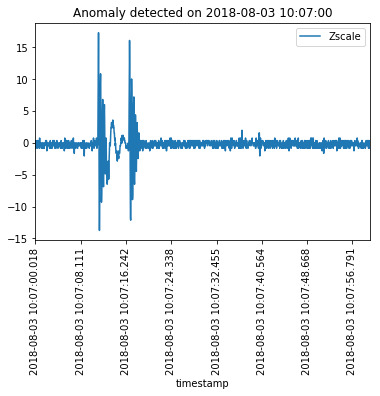

In [72]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-08-03 10:07:00")
plt.xticks(rotation=90)

### Anomaly 4

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

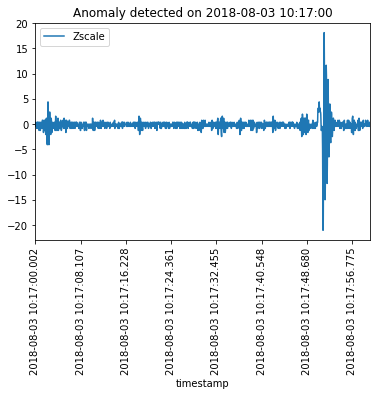

In [81]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-08-03 10:17:00")
plt.xticks(rotation=90)

### Anomaly 5

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

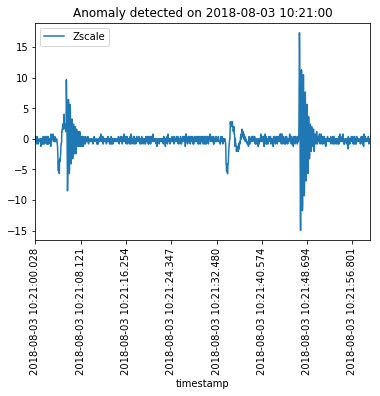

In [176]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-08-03 10:21:00")
plt.xticks(rotation=90)

### Anomaly 6

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

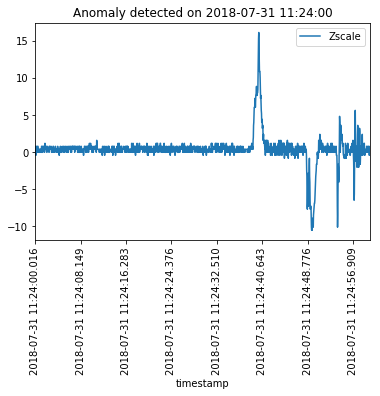

In [101]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-31 11:24:40")
plt.xticks(rotation=90)

### Anomaly 7

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

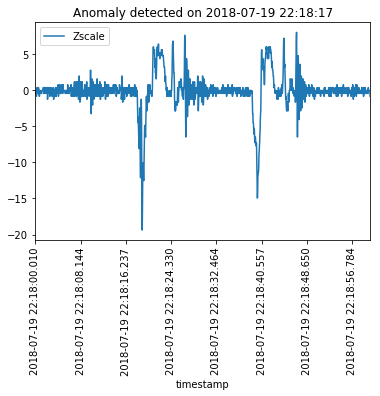

In [133]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-19 22:18:17")
plt.xticks(rotation=90)

### Anomaly 8 

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

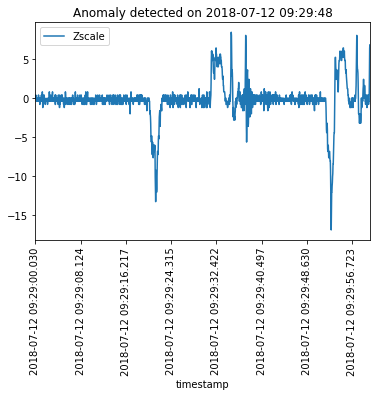

In [119]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-12 09:29:48")
plt.xticks(rotation=90)

### Anomaly 9### 

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

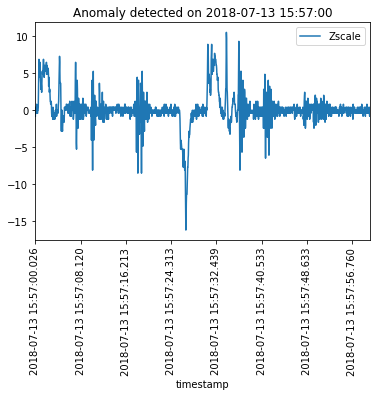

In [150]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-13 15:57:00")
plt.xticks(rotation=90)

### Anomaly 10 

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

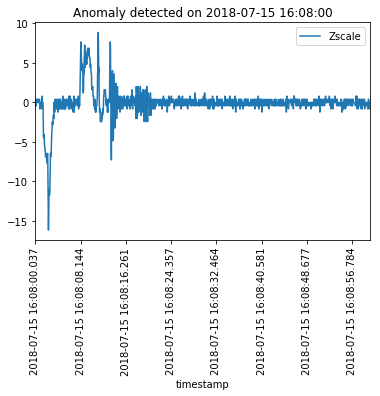

In [162]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-15 16:08:00")
plt.xticks(rotation=90)

In [177]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 14.2 ms, sys: 4.64 ms, total: 18.8 ms
Wall time: 173 ms


### Anomaly 1

(array([736909.41736111, 736909.41747685, 736909.41759259, 736909.41770833,
        736909.41782407, 736909.41793981]),
 <a list of 6 Text xticklabel objects>)

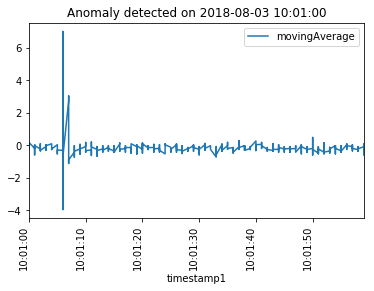

In [57]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-08-03 10:01:00")
plt.xticks(rotation=90)

### Anomaly 2

(array([736909.42013889, 736909.42025463, 736909.42037037, 736909.42048611,
        736909.42060185, 736909.42071759]),
 <a list of 6 Text xticklabel objects>)

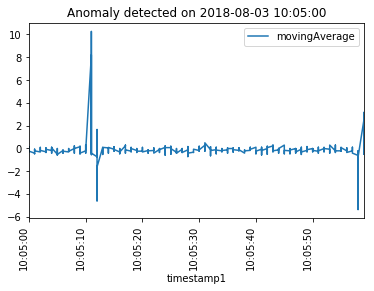

In [66]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-08-03 10:05:00")
plt.xticks(rotation=90)

### Anomaly 3

(array([736909.42152778, 736909.42164352, 736909.42175926, 736909.421875  ,
        736909.42199074, 736909.42210648]),
 <a list of 6 Text xticklabel objects>)

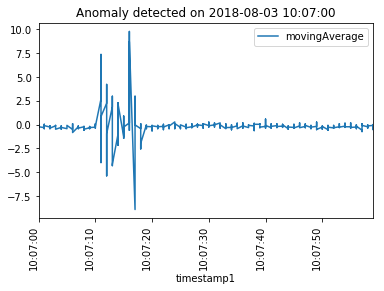

In [75]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-08-03 10:07:00")
plt.xticks(rotation=90)

### Anomaly 4

(array([736909.42847222, 736909.42858796, 736909.4287037 , 736909.42881944,
        736909.42893519, 736909.42905093]),
 <a list of 6 Text xticklabel objects>)

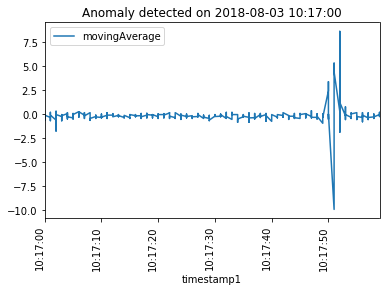

In [91]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-08-03 10:17:00")
plt.xticks(rotation=90)

### Anomaly 5 

(array([736909.43125   , 736909.43136574, 736909.43148148, 736909.43159722,
        736909.43171296, 736909.4318287 ]),
 <a list of 6 Text xticklabel objects>)

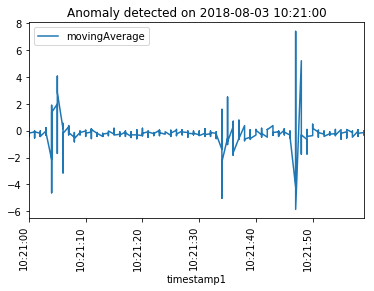

In [178]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-08-03 10:21:00")
plt.xticks(rotation=90)

### Anomaly 6 

(array([736906.475     , 736906.47511574, 736906.47523148, 736906.47534722,
        736906.47546296, 736906.4755787 ]),
 <a list of 6 Text xticklabel objects>)

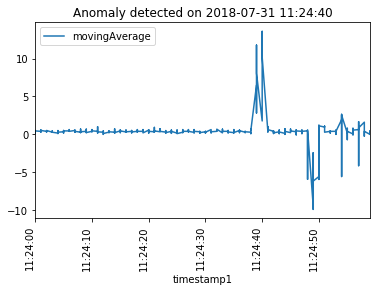

In [103]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-31 11:24:40")
plt.xticks(rotation=90)

### Anomaly 7 

(array([736894.92916667, 736894.92928241, 736894.92939815, 736894.92951389,
        736894.92962963, 736894.92974537]),
 <a list of 6 Text xticklabel objects>)

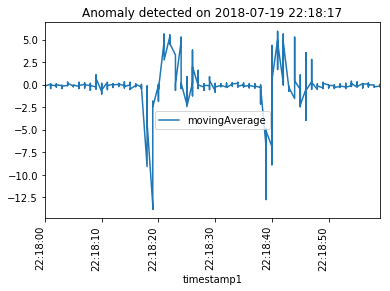

In [136]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-19 22:18:17")
plt.xticks(rotation=90)

### Anomaly 8 

(array([736887.39513889, 736887.39525463, 736887.39537037, 736887.39548611,
        736887.39560185, 736887.39571759]),
 <a list of 6 Text xticklabel objects>)

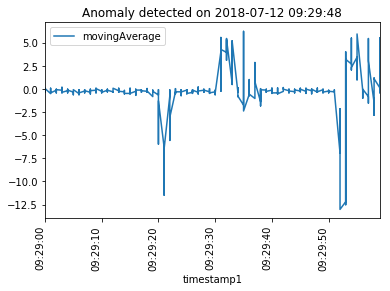

In [143]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-12 09:29:48")
plt.xticks(rotation=90)

### Anomaly 9 

(array([736888.66458333, 736888.66469907, 736888.66481481, 736888.66493056,
        736888.6650463 , 736888.66516204]),
 <a list of 6 Text xticklabel objects>)

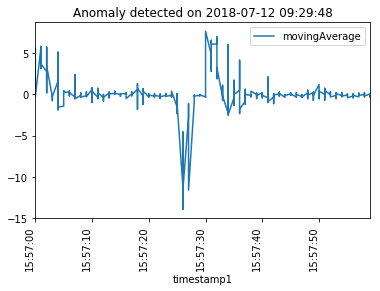

In [152]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-12 09:29:48")
plt.xticks(rotation=90)

### Anomaly 10 

(array([736890.67222222, 736890.67233796, 736890.6724537 , 736890.67256944,
        736890.67268519, 736890.67280093]),
 <a list of 6 Text xticklabel objects>)

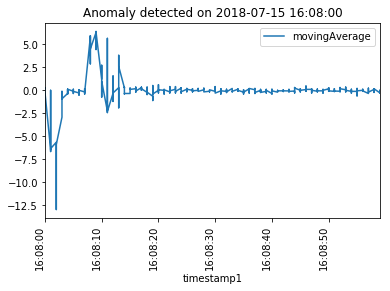

In [164]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-15 16:08:00")
plt.xticks(rotation=90)

## Normal Cases

### Normal Case 1

In [328]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 9.8 ms, sys: 628 µs, total: 10.4 ms
Wall time: 408 ms


In [303]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 15.3 ms, sys: 3.98 ms, total: 19.2 ms
Wall time: 217 ms


(array([   0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 6 Text xticklabel objects>)

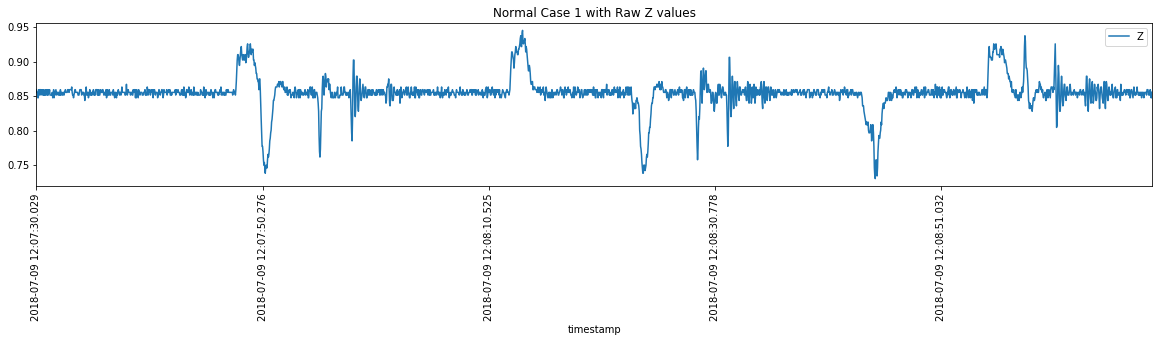

In [330]:
plt.rcParams["figure.figsize"] = (20,3)
temp_pandas.plot(x ='timestamp', y='Z', kind = 'line')

plt.title("Normal Case 1 with Raw Z values")
plt.xticks(rotation=90)


(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.,
        2250.]), <a list of 10 Text xticklabel objects>)

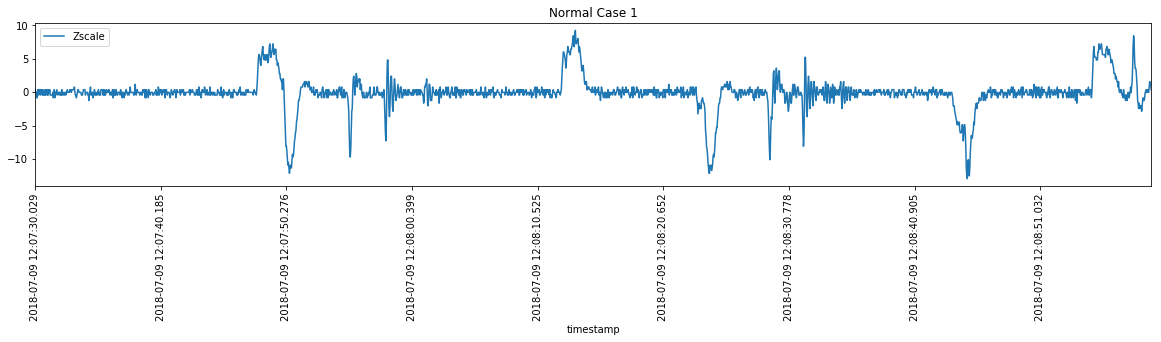

In [298]:
plt.rcParams["figure.figsize"] = (20,3)
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')

plt.title("Normal Case 1 with Z scale values")
plt.xticks(rotation=90)


(array([  0., 100., 200., 300., 400., 500.]),
 <a list of 6 Text xticklabel objects>)

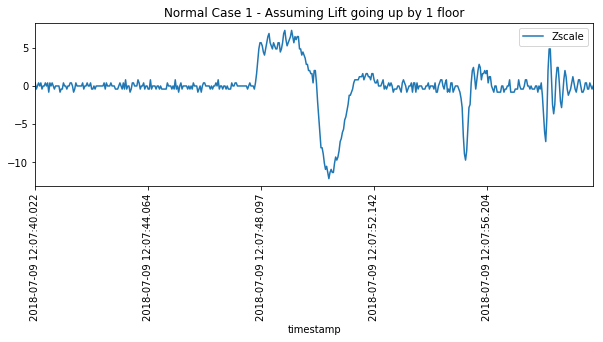

In [310]:
plt.rcParams["figure.figsize"] = (10,3)
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')

plt.title("Normal Case 1 - Assuming Lift going up by 1 floor")
plt.xticks(rotation=90)


(array([  0., 100., 200., 300., 400., 500.]),
 <a list of 6 Text xticklabel objects>)

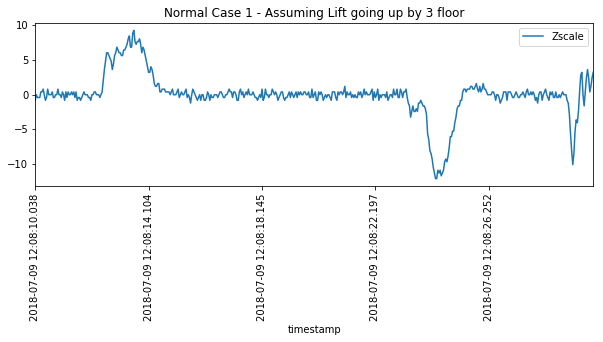

In [314]:
plt.rcParams["figure.figsize"] = (10,3)
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')

plt.title("Normal Case 2 - Assuming Lift going up by 3 floor")
plt.xticks(rotation=90)

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450.]),
 <a list of 10 Text xticklabel objects>)

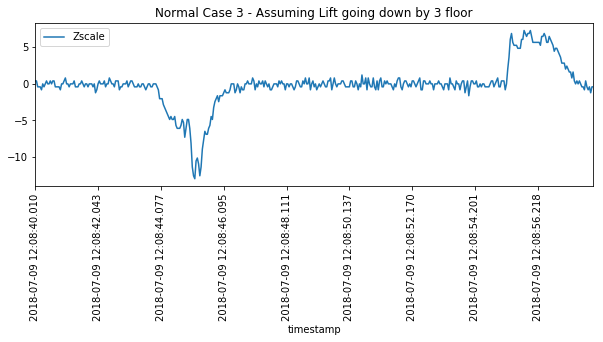

In [325]:
plt.rcParams["figure.figsize"] = (10,3)
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')

plt.title("Normal Case 3 - Assuming Lift going down by 3 floor")
plt.xticks(rotation=90)